# Calculate the number of unique experiments, participants, and foci

In [5]:
import os
import sys

# Imports
from pathlib import Path
import nibabel as nib
import nilearn.reporting
import pandas as pd
import nimare
import numpy as np
import SUITPy

# User-specified base working directory
BASE_DIR = '/data/project/cerebellum_ale/'  # Change this to your project folder. Make sure they have input and output folders.

# Defines input and output paths.
INPUT_DIR = os.path.join(BASE_DIR, 'input')
OUTPUT_DIR = os.path.join(BASE_DIR, 'output')

sys.path.append(os.path.join(BASE_DIR, 'scripts'))

In [6]:
# Load the CSV data
exp_stats_CSALE = pd.read_csv(os.path.join(OUTPUT_DIR, 'exp_stats_from_json_240814.csv'))

# Optional: If needed, preview the loaded data
print(exp_stats_CSALE.head())

                     subbd  n_exp  n_foci  n_subs
0                   Action    259    1280    3536
1         Action.Execution    198    1033    2544
2  Action.Execution.Speech     47     213     627
3       Action.Imagination     18      55     233
4        Action.Inhibition     36      87     588


In [7]:
# Extract the labels directly from the exp_stats_df -> this is just a simply lifehack for extracting the BD/ subdomain names.
combined_labels = exp_stats_CSALE['subbd'].tolist()
combined_labels

['Action',
 'Action.Execution',
 'Action.Execution.Speech',
 'Action.Imagination',
 'Action.Inhibition',
 'Action.Observation',
 'Cognition',
 'Cognition.Attention',
 'Cognition.Language',
 'Cognition.Language.Orthography',
 'Cognition.Language.Phonology',
 'Cognition.Language.Semantics',
 'Cognition.Language.Speech',
 'Cognition.Memory',
 'Cognition.Memory.Explicit',
 'Cognition.Memory.Working',
 'Cognition.Music',
 'Cognition.Reasoning',
 'Cognition.SocialCognition',
 'Cognition.Spatial',
 'Emotion',
 'Emotion.Negative',
 'Emotion.Negative.Anger',
 'Emotion.Negative.Disgust',
 'Emotion.Negative.Fear',
 'Emotion.Negative.Sadness',
 'Emotion.Positive',
 'Emotion.Positive.Happiness',
 'Emotion.Positive.RewardGain',
 'Interoception',
 'Interoception.Sexuality',
 'Perception',
 'Perception.Audition',
 'Perception.Olfaction',
 'Perception.Somesthesis',
 'Perception.Somesthesis.Pain',
 'Perception.Vision',
 'Perception.Vision.Color',
 'Perception.Vision.Motion',
 'Perception.Vision.Shape']

In [8]:
domains = ['Action', 'Cognition', 'Emotion', 'Perception', 'Interoception']

In [9]:
# Initialize sets and counters
unique_experiments = set()
unique_foci = set()
total_participants = 0

# Function to load NiMARE datasets, and extract unqieu studies, sum up the number of participants, and find the number of coordinates
def process_dataset(dset_path):
    global total_participants
    if os.path.exists(dset_path):
        # Load the dataset
        ds = nimare.dataset.Dataset.load(dset_path)
        
        # Extract and update unique experiments (using 'study_id' and 'contrast_id')
        experiments = zip(ds.metadata['study_id'], ds.metadata['contrast_id'])
        unique_experiments.update(experiments)
        
        # Flatten the sample sizes and sum them (ensure they are integers)
        flattened_sample_sizes = [int(size) for sublist in ds.metadata['sample_sizes'] for size in sublist]
        total_participants += sum(flattened_sample_sizes)
        
        # Add unique foci (coordinates)
        unique_foci.update(map(tuple, ds.coordinates[['x', 'y', 'z']].drop_duplicates().values))


In [10]:
# Loop through each label in combined_labels
for label in combined_labels:
    domain = label.split('.')[0]  # Extract the domain from the label, splitting at the first period within the name.
    
    # Construct the path for each dataset
    dset_path = os.path.join(OUTPUT_DIR, f'data/{domain}/{label}/dset.pkl.gz')
    
    # Process the dataset
    process_dataset(dset_path)

# Number of unique experiments, participants, and foci
num_unique_experiments = len(unique_experiments)
num_unique_foci = len(unique_foci)

print(f"Unique Experiments: {num_unique_experiments}")
print(f"Total Participants: {total_participants}")
print(f"Unique Foci: {num_unique_foci}")


Unique Experiments: 1129
Total Participants: 63350
Unique Foci: 4248


In [11]:
sys.path.append(os.path.join(BASE_DIR, 'scripts'))
from utils import get_null_xyz

In [14]:
null_xyz = get_null_xyz(null_dset_path=os.path.join(OUTPUT_DIR, 'data/BrainMap_dump_Feb2024_mask-D2009_MNI_dilated-6mm.pkl.gz'), mask_path=os.path.join(INPUT_DIR, 'maps/Grey10.nii.gz'), unique = False)

In [15]:
print(null_xyz.shape) # it appears some of the coordinates (<1000) fall outside of the Grey10 mask.

(62491, 3)


In [26]:
null_xyz = get_null_xyz(null_dset_path=os.path.join(OUTPUT_DIR, 'data/BrainMap_dump_Feb2024_mask-D2009_MNI_dilated-6mm.pkl.gz'), mask_path=os.path.join(INPUT_DIR, 'maps/D2009_MNI.nii.gz'), unique = False)

In [27]:
print(null_xyz.shape)

(3118, 3)


In [28]:
# Find unique coordinates
unique_null_xyz = np.unique(null_xyz, axis=0)

# Number of unique coordinates
num_unique_coords = unique_null_xyz.shape[0]

print(f"Number of unique coordinates: {num_unique_coords}")

Number of unique coordinates: 2773


In [52]:
# Plot the coordinates onto the cerebellar flatmap

<AxesSubplot: >

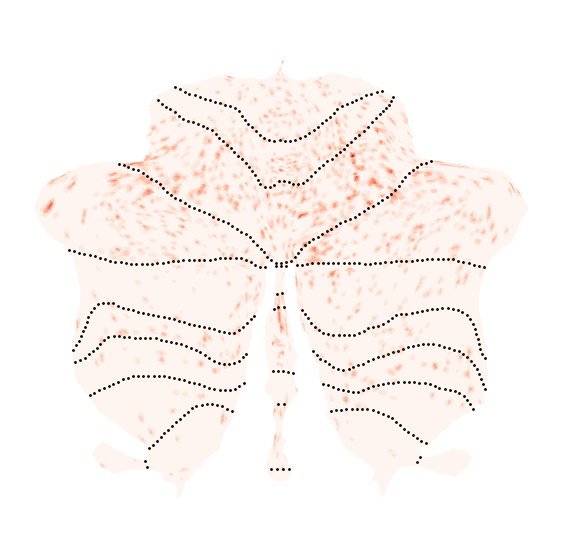

In [29]:
mni_temp = nilearn.datasets.load_mni152_template(resolution=1)
null_ijk = nib.affines.apply_affine(np.linalg.inv(mni_temp.affine), null_xyz).astype('int')
foci_img_data = np.zeros(mni_temp.shape)
foci_img_data[null_ijk[:,0], null_ijk[:, 1], null_ijk[:, 2]] = 1

# Dilate the foci to make them appear larger
# foci_img_data = binary_dilation(foci_img_data, iterations=1)  # Increase iterations to enlarge further
foci_img = nilearn.image.new_img_like(mni_temp, foci_img_data)
flat_img = SUITPy.vol_to_surf(foci_img, space='SPM')


SUITPy.flatmap.plot(flat_img, cmap = 'Reds')
    
# Save the figure to a file
# output_path = os.path.join(BASE_DIR, 'Figures/Publication/Graphical_abstract/foci_distribution_flatmap.png')
#plt.gcf().savefig(output_path, bbox_inches='tight', transparent=True)

# Close the display to avoid displaying it in interactive environments
# plt.close(fig)

# Number of experiments is straightforward

In [16]:
dset = nimare.dataset.Dataset.load(os.path.join(OUTPUT_DIR, 'data/BrainMap_dump_Feb2024_mask-D2009_MNI_dilated-6mm.pkl.gz'))

In [17]:
dset

Dataset(2415 experiments, space='mni152_2mm')

In [18]:
dset.coordinates['study_id']

41084    10010001
41082    10010001
41110    10010004
41115    10010004
41136    10020011
           ...   
40835     9110179
40836     9110179
40832     9110179
41000     9110182
40959     9110182
Name: study_id, Length: 4783, dtype: object

In [44]:
# Assuming dset.coordinates is a pandas DataFrame
unique_study_ids = dset.coordinates['study_id'].nunique()

print(f"Number of unique study IDs: {unique_study_ids}")

Number of unique study IDs: 1129


# For participants, we keep unique study_ids and then sum the participants.

In [48]:
metadata_merged = pd.DataFrame(columns=dset.metadata.columns[:6])
for i, (study_id, study_metadata) in enumerate(dset.metadata.groupby('study_id')):
    metadata_merged.loc[i, :] = {
        'id': f'{study_id}-0',
        'study_id': study_id,
        'contrast_id': 0,
        'sample_sizes': [int(study_metadata['sample_sizes'].apply(lambda c: c[0]).mean().round())],
        'author': study_metadata.iloc[0].loc['author'],
        'year': study_metadata.iloc[0].loc['year']
    }

In [49]:
metadata_merged

,id,study_id,contrast_id,sample_sizes,author,year
0,30001-0,30001,0,[12],Anderson N D,2000
1,30002-0,30002,0,[12],Arrington C M,2000
2,30004-0,30004,0,[8],Beason-Held L L,1998
3,30008-0,30008,0,[9],Buckner R L,2000
4,30011-0,30011,0,[20],Cabeza R,2002
...,...,...,...,...,...,...
1124,60100173-0,60100173,0,[8],Larsson J,1996
1125,60100174-0,60100174,0,[10],Lutz K,2000
1126,60100175-0,60100175,0,[8],Mattay V S,1998
1127,60100178-0,60100178,0,[10],Riecker A,2006


In [52]:
# Group by 'study_id' and sum the sample_size for each group
unique_study_metadata = metadata_merged.groupby('study_id', as_index=False).agg({
    'sample_sizes': 'sum',
    # You can add more columns here if needed, using appropriate aggregation functions
})

# Now, unique_study_metadata contains the unique study_ids with the summed sample_size
print(unique_study_metadata.head())  # Display the first few rows of the new DataFrame

  study_id sample_sizes
0    30001         [12]
1    30002         [12]
2    30004          [8]
3    30008          [9]
4    30011         [20]


In [54]:
total_sample_size = metadata_merged['sample_sizes'].apply(sum).sum()

print(f"Total summed sample size: {total_sample_size}")

Total summed sample size: 16410


# Let's also quickly check the number of experiments, participants, and foci from which the whole-brain probability distribution is made.
## We already know the number of foci from above: 62,491 (we allow duplicates in the construction of the probabilistic null space).

In [19]:
dset_full = nimare.dataset.Dataset.load(os.path.join(OUTPUT_DIR, 'data/BrainMap_dump_Feb2024_mask-Grey10.pkl.gz'))

In [20]:
dset_full

Dataset(8264 experiments, space='mni152_2mm')

In [21]:
dset_full.coordinates['study_id']

41067    10010001
41068    10010001
41065    10010001
41064    10010001
41066    10010001
           ...   
41058     9120184
41060     9120184
41056     9120184
41057     9120184
41059     9120184
Name: study_id, Length: 62491, dtype: object

In [22]:
metadata_merged_full = pd.DataFrame(columns=dset_full.metadata.columns[:6])
for i, (study_id, study_metadata) in enumerate(dset_full.metadata.groupby('study_id')):
    metadata_merged_full.loc[i, :] = {
        'id': f'{study_id}-0',
        'study_id': study_id,
        'contrast_id': 0,
        'sample_sizes': [int(study_metadata['sample_sizes'].apply(lambda c: c[0]).mean().round())],
        'author': study_metadata.iloc[0].loc['author'],
        'year': study_metadata.iloc[0].loc['year']
    }

In [23]:
metadata_merged_full

,id,study_id,contrast_id,sample_sizes,author,year
0,30001-0,30001,0,[12],Anderson N D,2000
1,30002-0,30002,0,[12],Arrington C M,2000
2,30004-0,30004,0,[8],Beason-Held L L,1998
3,30005-0,30005,0,[13],Beauregard M,1998
4,30006-0,30006,0,[12],Binder J R,1996
...,...,...,...,...,...,...
2201,60100174-0,60100174,0,[10],Lutz K,2000
2202,60100175-0,60100175,0,[8],Mattay V S,1998
2203,60100176-0,60100176,0,[15],Ongur D,2005
2204,60100178-0,60100178,0,[10],Riecker A,2006


In [24]:
total_sample_size_full = metadata_merged_full['sample_sizes'].apply(sum).sum()

print(f"Total summed sample size: {total_sample_size_full}")

Total summed sample size: 32485


# The End.